In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-likes-prediction-famous/sample_submission.csv
/kaggle/input/twitter-likes-prediction-famous/train.csv
/kaggle/input/twitter-likes-prediction-famous/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('/kaggle/input/twitter-likes-prediction-famous/train.csv')
test = pd.read_csv('/kaggle/input/twitter-likes-prediction-famous/test.csv')

<a id="1"></a> <br>
# 1. EDA
Как видно, есть текст твита и тема (ключевое слово), а также сколько лайков он твит набрал.

In [4]:
train.head()

,keyword,likes,tweets
0,COVID-19,1,The headline kinda makes it sound like the AP ...
1,COVID-19,0,ATLANTIC CITY — The city's Police Athletic Lea...
2,COVID-19,0,I feel like Diana's line she draws is if his s...
3,COVID-19,1,COVID-19 was the single most fatal communicabl...
4,COVID-19,0,Studies: Dogs can detect COVID-19 with greater...


In [5]:
test.head()

,id,keyword,tweet
0,1,COVID-19,The first idiot was leaving space for an Eleph...
1,2,COVID-19,Do you have any suggestions? How can we improv...
2,3,COVID-19,"Amazing from outside , but it has blood stain ..."
3,4,COVID-19,I'm tryin to black out into the new year 💁🏻‍♂️
4,5,COVID-19,Yes it is ... and Kabir Sahab is right .. we s...


In [6]:
test = test.rename(columns={'tweet': 'tweets'})
test.head()

,id,keyword,tweets
0,1,COVID-19,The first idiot was leaving space for an Eleph...
1,2,COVID-19,Do you have any suggestions? How can we improv...
2,3,COVID-19,"Amazing from outside , but it has blood stain ..."
3,4,COVID-19,I'm tryin to black out into the new year 💁🏻‍♂️
4,5,COVID-19,Yes it is ... and Kabir Sahab is right .. we s...


In [7]:
train.shape

(128837, 3)

In [8]:
train.describe()

,likes
count,128837.000000
mean,23.898453
std,584.283219
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,82843.000000


Сразу видно, что тема твита влияет на твиты с очень большим количеством лайков, в темах где таких твитов много, отклонение большое.

In [9]:
pd.concat([train.groupby('keyword').agg({'likes': 'mean'}).sort_values(by='keyword', ascending=False).reset_index() \
           .rename(columns={'likes': 'mean_likes'}), 
         train.groupby('keyword').agg({'likes': 'std'}).sort_values(by='keyword', ascending=False).reset_index() \
          .rename(columns={'likes': 'std'}).drop(columns=['keyword'])],
         axis=1).sort_values('mean_likes', ascending=False)

,keyword,mean_likes,std
27,Dogecoin,173.150776,1949.775795
30,Bitcoin,62.279344,998.191221
20,Johnny Depp,59.398520,1389.416514
17,Netflix,49.818436,878.043564
15,Queen Elizabeth,46.217157,737.399537
6,World Cup,40.791642,675.562595
2,nba,38.551090,772.126909
23,India vs England,32.572115,522.336150
25,Facebook,28.689848,755.161420
1,porn,27.723005,278.424718


Целая половина твитов вообще имеют 0 лайков, всего 3% имеют 50+ лайков и лишь 0.28% имеют 1000+ лайков. Такие твиты с более чем 1000 лайков можно отнести к выбросам.

In [10]:
zero_likes_num = train[train.likes == 0].shape[0]
likes50_num = train[train.likes > 50].shape[0]
likes1000_num = train[train.likes > 999].shape[0]

print(f"""In train data {zero_likes_num} tweets ({round(
zero_likes_num/train.shape[0]*100,2)}%) have zero likes. {likes50_num} tweets \
({round(likes50_num/train.shape[0]*100,2)}%) have 50+ likes. And only \
{likes1000_num} ({round(likes1000_num/train.shape[0]*100,2)}%) have \
1000+ likes.""")

In train data 65573 tweets (50.9%) have zero likes. 3627 tweets (2.82%) have 50+ likes. And only 357 (0.28%) have 1000+ likes.


<Axes: xlabel='likes', ylabel='Count'>

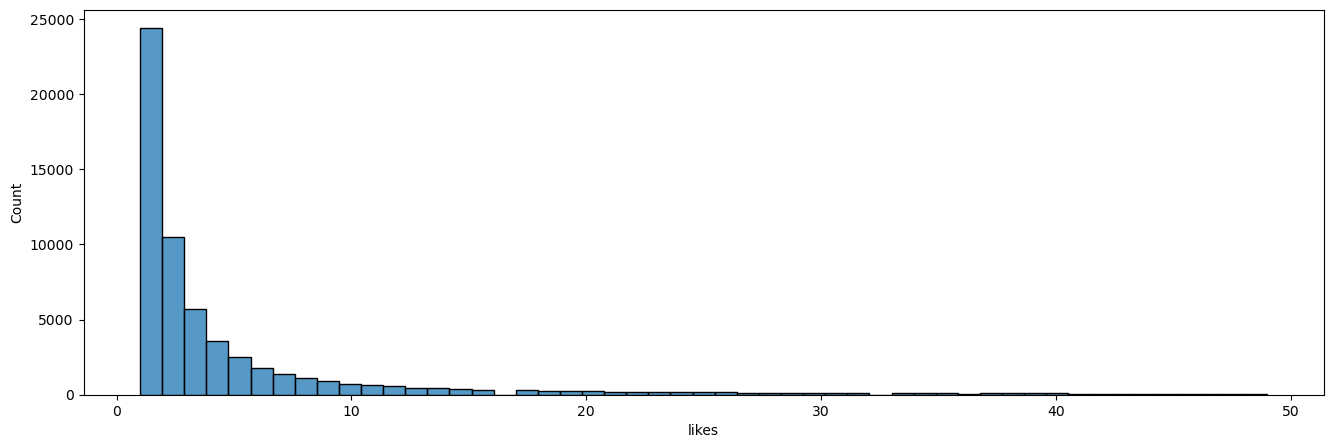

In [11]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(x=train[(train.likes>0) & (train.likes<50)].likes,bins=51)

Из графиков видно, что по некоторым темам вероятность получить хотя бы 1 лайк выше, чем по другим. Также твиты о Джонни Деппе получают больше лайков относительно остальных.

Text(0.5, 1.0, 'Tweets with 1000+ likes')

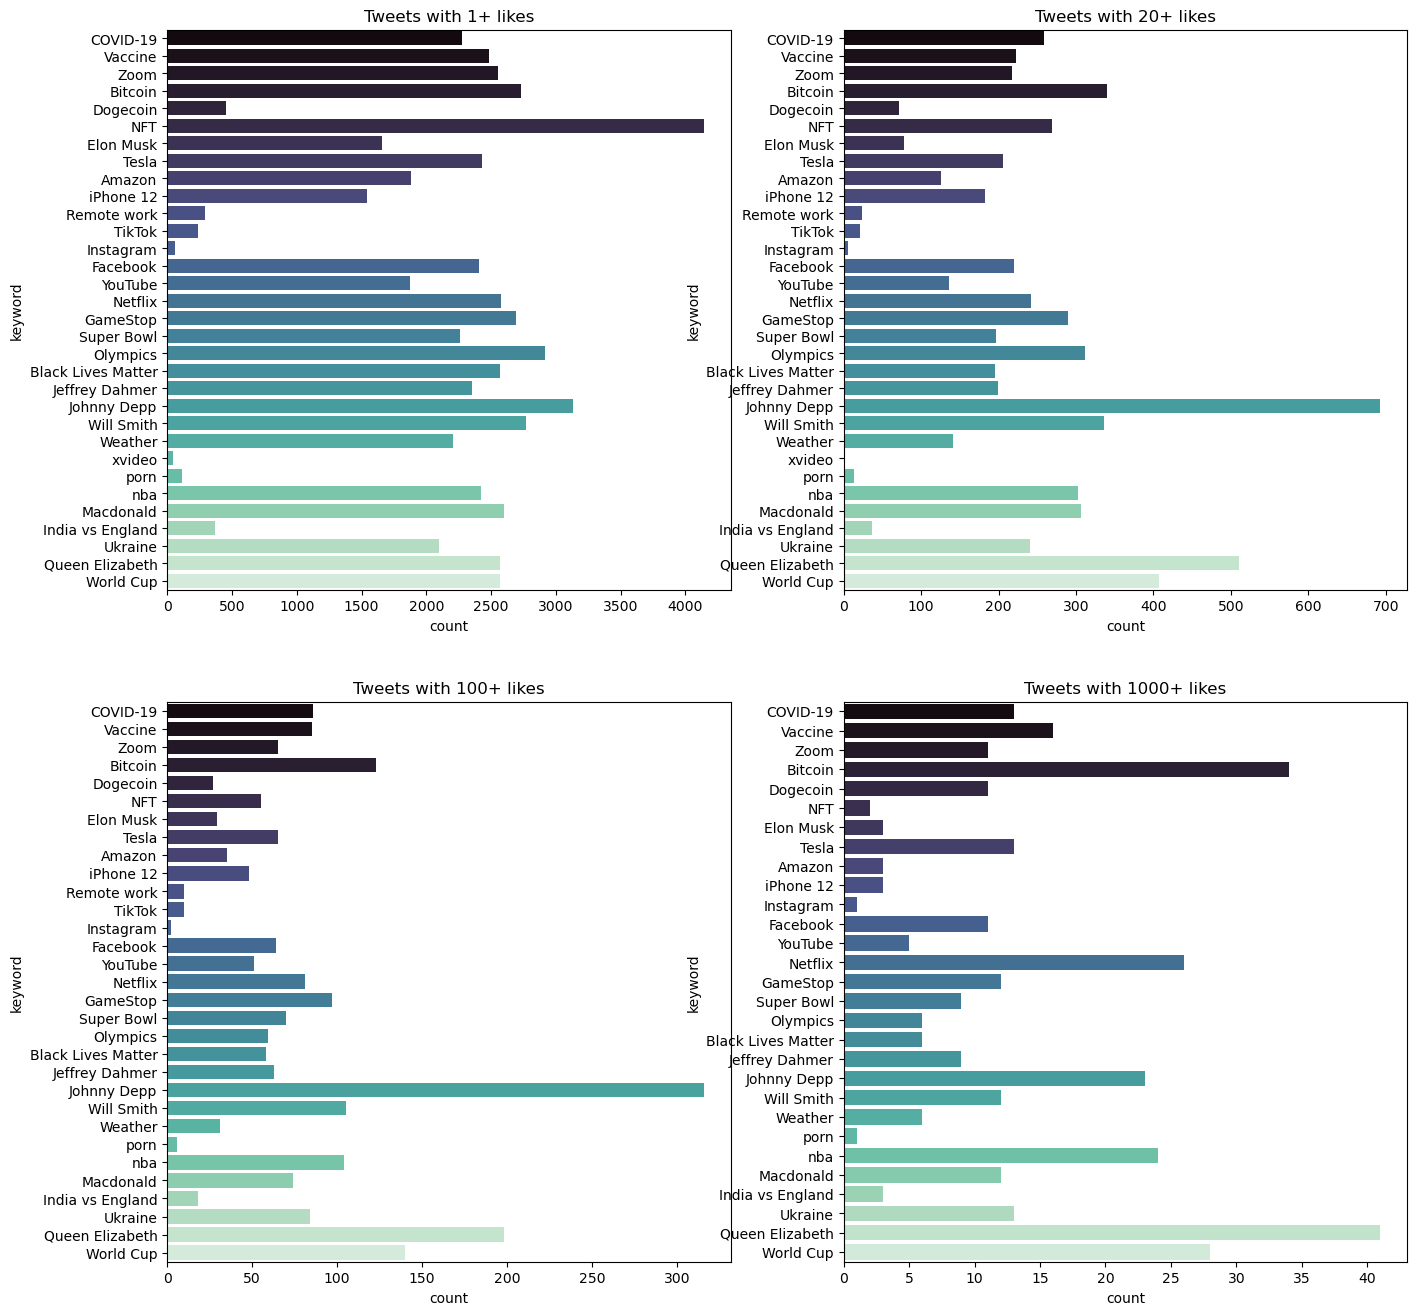

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
sns.countplot(y=train[train.likes>0].keyword, ax=ax[0][0],palette='mako')
ax[0][0].set_title('Tweets with 1+ likes')
sns.countplot(y=train[train.likes>20].keyword, ax=ax[0][1],palette='mako')
ax[0][1].set_title('Tweets with 20+ likes')
sns.countplot(y=train[train.likes>99].keyword, ax=ax[1][0],palette='mako')
ax[1][0].set_title('Tweets with 100+ likes')
sns.countplot(y=train[train.likes>999].keyword, ax=ax[1][1],palette='mako')
ax[1][1].set_title('Tweets with 1000+ likes')

In [13]:
train = train[train.likes <= 1000]

In [14]:
train.shape

(128480, 3)

Пробовал: <br>
prajjwal1/bert-mini <br>
prajjwal1/bert-small <br>
prajjwal1/bert-medium <br>
Twitter/TwHIN-BERT-base он почему-то показал очень посредственный результат, а также большеват, скорее всего переобучился, но после нескольких попыток результаты так и не улучшались <br> 
В итоге лучший результат показал чистый bert-medium, также пробовал их стакать между собой и с CatBoost, об этом подробнее ниже.

In [29]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
bert_model = "prajjwal1/bert-medium"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
config = AutoConfig.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model, output_hidden_states=True)

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
!pip install transformers pytorch_lightning torchmetrics lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00


Нужно понять какой длины твиты в датасетах.

In [18]:
train['set'] = 'train'
test['set'] = 'test'
df = pd.concat([train[['tweets', 'set']], test[['tweets', 'set']]])
df['sentence_len'] = df['tweets'].apply(lambda x: len(x.split()))

(0.0, 250.0)

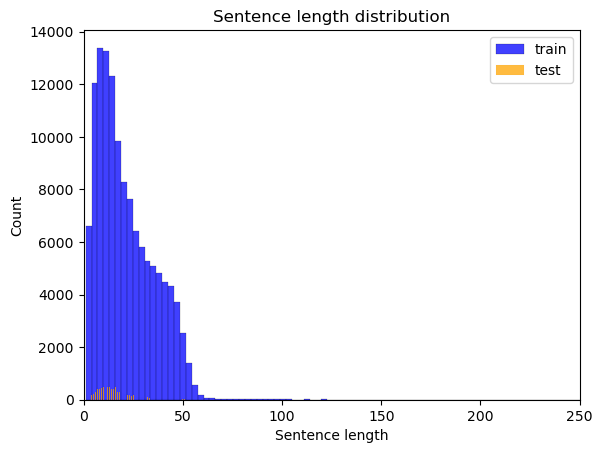

In [19]:
sns.histplot(df, x=df[df.set == 'train'].sentence_len, color='blue', bins=250)
sns.histplot(df, x=df[df.set == 'test'].sentence_len, color='orange', bins=250)
plt.legend(['train', 'test'])
plt.xlabel('Sentence length')
plt.title('Sentence length distribution')
plt.xlim(0, 250)

Как видно из графика, 64 нас вполне должно устроить.

In [30]:
corpus = tokenizer((train.keyword+" "+train.tweets).tolist(),
          add_special_tokens=True,
          padding='max_length',
          truncation='longest_first',
          max_length=64,
          return_attention_mask=True,
          return_tensors='pt')

In [31]:
input_ids = np.array(corpus['input_ids'])
attention_mask = np.array(corpus['attention_mask'])
labels = train.likes.to_numpy()

In [32]:
from sklearn.model_selection import train_test_split as tts
train_inputs, val_inputs, train_labels, val_labels, train_masks, val_masks, X_train, X_val = \
            tts(input_ids, labels, attention_mask, train, train_size=0.9,
                             random_state=68)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_labels.reshape(-1, 1))
train_labels = scaler.transform(train_labels.reshape(-1, 1))
val_labels = scaler.transform(val_labels.reshape(-1, 1))

In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader


batch_size = 16
num_workers = 2

def create_dataloaders(inputs, masks, labels, batch_size, shuffle=True):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, labels_tensor)
    dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle
        )
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
val_dataloader = create_dataloaders(val_inputs, val_masks,
                                     val_labels, batch_size, shuffle=False)
#train_noshuf_dataloader = create_dataloaders(train_inputs, train_masks,
#                                      train_labels, batch_size, shuffle=False)

In [35]:
import torch.nn as nn


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

class ImportedBERT(nn.Module):

    def __init__(self, drop_rate=0.2):

        super().__init__()
        num_in, num_out = 512, 1

        self.transferred = model
        self.output = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(num_in, num_out))

    def forward(self, input_ids, attention_masks):

        outputs = self.transferred(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.output(class_label_output)

        return outputs

Using GPU.


In [36]:
import pytorch_lightning as pl
from torch.nn.utils.clip_grad import clip_grad_norm_
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
    
class Regressor(pl.LightningModule):

    def __init__(self, model, lr=5e-5, eps=1e-8):
        super().__init__()

        self.model = model
        self.optimizer = AdamW(self.model.parameters(), lr=lr, eps=eps)
        self.loss = RMSELoss()
        self.eps = eps

    def forward(self, inp, mask):
        return self.model(inp, mask)

    def training_step(self, tr_batch, batch_idx):

        inputs, masks, labels = tr_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze().float(), labels.squeeze().float())
#         clip_grad_norm_(model.parameters(), 2)

        self.log(
            "train_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

    def validation_step(self, val_batch, batch_idx):

        inputs, masks, labels = val_batch
        outputs = self.model(inputs, masks)
        loss = self.loss(outputs.squeeze(), labels.squeeze())

        self.log(
            "val_loss",
            loss,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss.float()


    def configure_optimizers(self):

#         scheduler = get_linear_schedule_with_warmup(
#             self.optimizer,
#             num_warmup_steps=0,
#             num_training_steps=self.trainer.estimated_stepping_batches,
#         )
#         scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}

        return {"optimizer": self.optimizer}

In [37]:
bert = ImportedBERT(drop_rate=0.2)
comp = Regressor(bert).to(device)

trainer = pl.Trainer(
    max_epochs=3,
#     logger=wandb_logger,
    enable_checkpointing=True
)

trainer.fit(comp, train_dataloader, val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

In [38]:
trainer.validate(comp, val_dataloader)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.4812151259682821     │
└───────────────────────────┴───────────────────────────┘

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[{'val_loss': 0.4812151259682821}]

In [40]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model.model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [41]:
y_pred_val = predict(comp.to(device), val_dataloader, device)
y_pred_val = scaler.inverse_transform(np.array(y_pred_val).reshape(-1, 1))
from sklearn.metrics import mean_squared_error
print(f'Validation MSE: {mean_squared_error(val_labels, y_pred_val)}')
print(f'Validation RMSE: {np.sqrt(mean_squared_error(val_labels, y_pred_val))}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation MSE: 2.6888529565121164
Validation RMSE: 1.6397722270218253


Результат вполне неплохой, дальше я пробовал стакать предсказания разных моделей между собой, а также с Catboost, но public score наивысший получился у чистого bert-medium.

In [ ]:
y_pred_train = predict(comp.to(device), train_noshuf_dataloader, device)
y_pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(-1, 1))
from sklearn.metrics import mean_squared_error
print(f'Train MSE: {mean_squared_error(train_labels, y_pred_train)}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(train_labels, y_pred_train))}')

In [43]:
encoded_val_corpus = \
                tokenizer(text=(test.keyword+" "+test.tweets).tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=64,
                          return_attention_mask=True,
                          return_tensors='pt')
test_input_ids = np.array(encoded_val_corpus['input_ids'])
test_attention_mask = np.array(encoded_val_corpus['attention_mask'])

test_dataloader = create_dataloaders(test_input_ids, 
                                     test_attention_mask,
                                     np.ones(test_input_ids.shape[0]),
                                     batch_size, shuffle=False)
y_pred = predict(comp.to(device), test_dataloader, device)
y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
predictions = pd.DataFrame({'id': test.id,
                            'likes': y_pred.ravel()})
predictions.to_csv('/kaggle/working/bert-medium.csv', index=False)

In [ ]:
X_train = X_train.drop(columns=['likes'])
X_val = X_val.drop(columns=['likes'])

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
X_train['bert_pred'] = y_pred_train.ravel()
X_val['bert_pred'] = y_pred_val.ravel()
X_train.head()

In [ ]:
pool_train = Pool(
    X_train, train_labels,
    text_features=['tweets'],
    cat_features=['keyword']
)
pool_val = Pool(
    X_val, val_labels,
    text_features=['tweets'],
    cat_features=['keyword']
)

In [ ]:
print(f"Val MSE: {mean_squared_error(val_labels, X_test['bert_pred'])}")
print(f"Val RMSE: {np.sqrt(mean_squared_error(val_labels, X_test['bert_pred']))}")

In [ ]:
cbr = CatBoostRegressor(iterations=5000, learning_rate=0.01, loss_function='RMSE', use_best_model=True)

In [ ]:
cbr.fit(pool_train, eval_set=pool_val, verbose=500)

In [ ]:
pred_cbr = cbr.predict(X_test)
print(f'Train MSE: {mean_squared_error(val_labels, pred_cbr)}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(val_labels, pred_cbr))}')

In [ ]:
test['bert_pred'] = y_pred

In [ ]:
test = test.drop(columns=['id'])

In [ ]:
pred_test_cbr = cbr.predict(test)

In [ ]:
predictions = pd.DataFrame({'id': test.id,
                            'likes': y_pred.ravel()})
predictions.to_csv('/kaggle/working/bert+cbr.csv', index=False)